In [84]:
import os
import time
os.getcwd()

'/Users/socialai/Documents/GitHub/agentarium/examples/state_punishment/notebooks'

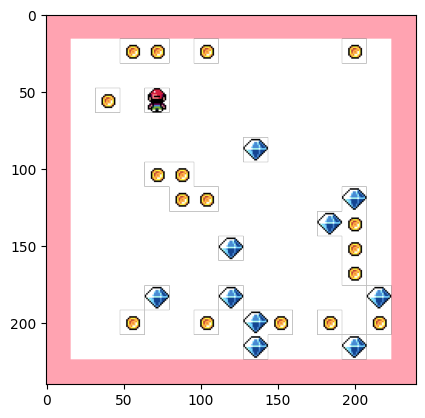

1.0
[56]


In [113]:
%load_ext autoreload

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

from examples.state_punishment.utils import (
    init_log, parse_args, load_config,
    create_models,
    create_agents,
    create_entities,
)
config_path = '../configs/records/fixed_punishment_rate_1.0_oneAs_size16_gem_has_value_epsilon0.99_config_backup.yaml'
from examples.state_punishment import agents, entities
from examples.state_punishment.env import state_punishment
from agentarium.logging_utils import GameLogger
from agentarium.models import human_player
from agentarium.utils import visual_field_sprite, image_from_array
from examples.state_punishment.state_sys import state_sys
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import argparse

cfg = load_config(argparse.Namespace(config=config_path))

models = create_models(cfg)
agents = create_agents(cfg, models)
entities = create_entities(cfg)
env = state_punishment(cfg, agents, entities)

for ixs, agent in enumerate(agents):
    # agent.model = human_player.ModelHumanPlayer(
    #      action_space=4, 
    #      state_size = cfg.model.iqn.parameters.state_size, 
    #      extra_percept_size = cfg.model.iqn.parameters.extra_percept_size,
    #      memory_size=1, 
    #      name=f'human {ixs}')
    # agent.model.load(
    #      f'../models/checkpoints/fixed_punishment_rate_0.75_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_agent{ixs}_iRainbowModel_20241127-04111732699956.pkl')
    agent.model.load(
         '../models/checkpoints/fixed_punishment_rate_1.0_oneAs_size16_gem_has_value_epsilon0.99_agent0_iRainbowModel_20241128-22111732851733.pkl'
    )
    agent.model.epsilon = 0.01


for epoch in range(1):
    # Reset the environment at the start of each epoch
        env.reset()
        images_anim = []
        # for agent in env.agents:
        #     agent.reset(env)
        random.shuffle(agents)

        scores = GameLogger(max_epochs=1)

        # initialize state system
        state_entity = state_sys(
            cfg.state_sys.init_prob, 
            cfg.state_sys.magnitude, 
            cfg.state_sys.taboo,
            cfg.state_sys.change_per_vote
            )
        
        env.cache['delayed_r'] = [0 for _ in range(len(agents))]

        done = 0 
        turn = 0
        losses = 0
        game_points = [0 for _ in range(len(agents))]

        while not done:

            turn = turn + 1

            entities = env.get_entities_for_transition()
            # Entity transition
            for entity in entities:
                entity.transition(env)

            img = visual_field_sprite(env.world, tile_size = env.tile_size)
            clear_output(wait = True)
            # scores.pretty_print(
            #      'jupyter-mode',
            #      epoch = epoch,
            #      turn = turn,
            #      reward = game_points,
            # )
            
            img = image_from_array(img)
            time.sleep(0.1)
            plt.imshow(img)
            plt.show()
            images_anim.append(img)
            print(state_entity.prob)
            print(game_points)


            # Agent transition
            for agent in agents:

                (state,
                action,
                reward,
                next_state,
                done_
                ) = agent.transition(env, state_entity)

                img = visual_field_sprite(env.world, tile_size = env.tile_size)
                img = image_from_array(img)
                # print(agent.model.name)
                # plt.imshow(img)
                plt.show()
                # if agent.ixs == 0:
                #      images_anim.append(img)

                if turn >= cfg.experiment.max_turns or done_:
                    done = 1

                exp = (1, (state, action, reward, next_state, done))
                # agent.episode_memory.append(exp)

                game_points[agent.ixs] += reward

In [81]:
agent.cfg

In [70]:
import numpy as np

In [79]:
from PIL import Image
import imageio.v3 as iio
def create_gif_from_arrays(image_arrays, output_path, duration=100, loop=0):
    """
    Create a GIF from a sequence of images in NumPy array format.

    Args:
        image_arrays (list of np.ndarray): Sequence of images as NumPy arrays.
        output_path (str): Path to save the output GIF.
        duration (int): Duration of each frame in milliseconds (controls speed).
        loop (int): Number of times the GIF should loop (0 for infinite).
    """
    # Convert NumPy arrays to PIL Images
    if type(image_arrays[0]) != Image.Image:
        pil_images = [Image.fromarray(img) for img in image_arrays]
    else:
        pil_images = image_arrays
    
    # Save as GIF
    pil_images[0].save(
        output_path,
        save_all=True,
        append_images=pil_images[1:],
        duration=duration,
        loop=loop
    )
    print(f"GIF saved at {output_path}")


def create_gif_iio(images, output_path, fps=10):
    """
    Create a GIF from a list of image arrays using `imageio`.

    Args:
        images (list of numpy.ndarray): A list of image arrays (e.g., RGB or grayscale).
        output_path (str): Path to save the generated GIF.
        fps (int): Frames per second, controlling the speed of the GIF.
    """
    # Calculate the duration per frame in seconds
    duration_per_frame = 1 / fps
    
    # Save the GIF
    iio.imwrite(output_path, images, format="GIF", duration=duration_per_frame)
    print(f"GIF saved at {output_path}")


from PIL import Image, ImageDraw

from PIL import Image

def create_gif_from_pil_force_clean(image_list, output_path, duration=100, loop=0, background_color=(0, 0, 0)):
    """
    Create a GIF from a list of `PIL.Image.Image` objects, ensuring no shadow artifacts.
    Ensures each frame has a fresh background.

    Args:
        image_list (list of PIL.Image.Image): Sequence of PIL images.
        output_path (str): Path to save the output GIF.
        duration (int): Duration of each frame in milliseconds (controls speed).
        loop (int): Number of times the GIF should loop (0 for infinite).
        background_color (tuple): RGB color to reset the background for each frame.
    """
    # Determine the size of the images
    width, height = image_list[0].size

    # Ensure all frames are re-rendered on a clean background
    cleaned_frames = []
    for img in image_list:
        # Create a blank canvas for each frame
        blank_frame = Image.new(mode=img.mode, size=(width, height), color=background_color)
        
        # Convert the image to RGBA to handle transparency (if needed)
        if img.mode != "RGBA":
            img = img.convert("RGBA")
        
        # Paste the current frame onto the blank canvas
        blank_frame.paste(img, (0, 0), mask=img if img.mode == "RGBA" else None)
        cleaned_frames.append(blank_frame)

    # Save as GIF
    cleaned_frames[0].save(
        output_path,
        save_all=True,
        append_images=cleaned_frames[1:],
        duration=duration,
        loop=loop
    )
    print(f"GIF saved at {output_path}")


In [80]:
# from examples.state_punishment.utils import create_gif_from_arrays
print(type(images_anim[0]) == Image.Image)
create_gif_from_pil_force_clean(images_anim, 'movie_punishment_0.75_gem_has_value_diff_models.gif', 200)


True
GIF saved at movie_punishment_0.75_gem_has_value_diff_models.gif
